# Data Project

From Scrapping to Deploy it in a Streamlit App : Make all the cycle of the Data 



## Summary

- Import libraries
- Extraction of the data With Selenium (+ stockage in mongoDb)
- Treatment of the Data 
- Analyze the Data
- Streamlit Application 

## Import Librarries

In [35]:
# Scrappe and Clean
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pandas as pd
import urllib
import re
import requests
import csv
import time
import pyarrow.parquet as pq
from pymongo import MongoClient
import numpy as np
from selenium.webdriver.common.service import Service
from selenium.webdriver.common.service import Service
from fake_useragent import UserAgent
from urllib3.exceptions import NewConnectionError
import logging

# EDA

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


In [2]:
!pip install fake-useragent


## Extraction Data from website

### Website 1   : https://www.wineandco.com/

In [3]:

from urllib3.exceptions import NewConnectionError
import logging

ua = UserAgent()
user_agent = ua.random

options = webdriver.FirefoxOptions()
options.add_argument('--headless')
options.add_argument(f'user-agent={user_agent}')

all_data = []

logging.basicConfig(filename='scraping.log', level=logging.ERROR)

for page in range(0,1):
   
    print(f'début scrape de la page {page}')
    driver = webdriver.Firefox(options=options, executable_path='/path/to/geckodriver')
    try:
        driver.get(f'https://www.wineandco.com/vins#page_type=taxon&category_id=2&pageNumber={page}')
    except NewConnectionError:
        logging.error(f'Could not establish connection to page {page}, retrying...')
        time.sleep(10)
        try:
            driver.get(f'https://www.wineandco.com/vins#page_type=taxon&category_id=2&pageNumber={page}')
        except Exception as e:
            logging.error(f'Failed to scrape page {page}: {e}')
            driver.quit()
            continue
    time.sleep(2)

    # Handle cookie
    try:
        cookie_button = driver.find_element(By.CLASS_NAME, 'm-modal__close')
        cookie_button.click()
    except:
        pass

    # obtention des liens produits
    product_links = [x.get_attribute('href') for x in driver.find_elements(By.XPATH,'//div[@class="c-wine"]/a')]

    # Loop through product links
    for link in product_links:
        # hop dans la page produit :)
        driver.get(link)
        time.sleep(0.1)

        # prise data fiche produit
        product = driver.find_element(By.CLASS_NAME, "l-product")

        # function annexe pour recolter 
        def extract_data(xpath):
            try:
                data = product.find_element(By.XPATH, xpath).get_attribute('textContent')
            except:
                data = ""
            return data

        # informations
        name = extract_data('//h1[@class="l-product__infos__name"]')
        price = extract_data('//span[@class="price-display"]')
        rating = extract_data('//div[@class="l-product__infos__avist"]/span')

        product_info = driver.find_elements(By.CLASS_NAME,"c-product-characteristics__container")

        # prendre les characteristics spé de chaque vin ( se trouve dans une div , puis dans une liste)
        product_div = driver.find_element(By.CLASS_NAME, 'c-product-characteristics__container')
        characteristics = []

        # naviguer sur la liste , recup les donnés
        for ul in product_div.find_elements(By.TAG_NAME, 'ul'):
            for li in ul.find_elements(By.TAG_NAME, 'li'):
                characteristic = {}

                # récuperer en couple chaque donnée
                label = li.find_element(By.CLASS_NAME, 'c-product-characteristics__label').text
                text = li.find_element(By.CLASS_NAME, 'c-product-characteristics__text').text

                # stock dans un dictionnaire annexe
                characteristic[label] = text
                characteristics.append(characteristic)

        # Stock tout dans le dictionnaire ( data + dictionnaire caractéristiques)
        data = {'name': name, 'price': price, 'rating': rating, 'characteristics': characteristics}
        all_data.append(data)

    # fermeture du webdriver
    driver.quit()

print('fin du scrape')

# Insertion données dans la db
client = MongoClient('mongodb://127.0.0.1:27017/?directConnection=true&serverSelectionTimeoutMS=2000&appName=mongosh+1.8.0')
db = client['Project_final_Ydays']
collection = db['wine']
collection.insert_many(all_data)
print("la donnée est bien arrivée")
client.close()



début scrape de la page 0


C:\Users\yskon\AppData\Local\Temp\ipykernel_21120\349845635.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(options=options, executable_path='/path/to/geckodriver')


fin du scrape
la donnée est bien arrivée


## Load The Data From Db + Clean

In [4]:


# Connection
client = MongoClient('mongodb://127.0.0.1:27017/?directConnection=true&serverSelectionTimeoutMS=2000&appName=mongosh+1.8.0')


db = client['Project_final_Ydays']
collection = db['wine']

# Query , recup sous forme de list
data = list(collection.find())

# conversion en dataframe
df = pd.DataFrame(data)


client.close()

In [5]:
df.head()


,_id,name,price,rating,characteristics
0,644d628e5d3b9d87ff312ef8,\n Domaine la Lôyan...,"9,90 €",,"[{'Domaine': 'Domaine La Lôyane'}, {'Pays': 'F..."
1,644d628e5d3b9d87ff312ef9,\n M. Chapoutier le...,"8,50 €",,"[{'Domaine': 'M. Chapoutier'}, {'Pays': 'Franc..."
2,644d628e5d3b9d87ff312efa,\n La Seigneurie Sa...,"12,00 €",,"[{'Domaine': 'La Seigneurie'}, {'Pays': 'Franc..."
3,644d628e5d3b9d87ff312efb,\n Domaine de Beyss...,"10,90 €",,"[{'Domaine': 'Domaine De Beyssac'}, {'Pays': '..."
4,644d628e5d3b9d87ff312efc,\n Domaine la Lôyan...,"9,90 €",,"[{'Domaine': 'Domaine La Lôyane'}, {'Pays': 'F..."


In [6]:
df.isnull().sum()

_id                0
name               0
price              0
rating             0
characteristics    0
dtype: int64

In [7]:
import pandas as pd
import re






df['name'] = df['name'].str.replace('\n', '')


df['price'] = df['price'].str.replace('€', '')





df = df.astype(str)

def process_characteristics(s):
    # Remove the brackets around the string
    s = s.strip('[]')
    # Split the string by comma, excluding those inside curly braces
    parts = re.findall(r'{[^}]+}|[^,]+', s)
    # Create a dictionary to store the key-value pairs
    d = {}
    # Loop through the parts and extract the key-value pairs
    for part in parts:
        if ':' in part:
           
            key, value = map(str.strip, part.split(':', 1))
           
            d[key] = value
    return d



df['characteristics'] = df['characteristics'].apply(process_characteristics)


df = pd.concat([df.drop(['characteristics'], axis=1), df['characteristics'].apply(pd.Series)], axis=1)


df = df.rename(columns=lambda x: re.sub('\s+', '', x))


print(df.head())

                        _id  \
0  644d628e5d3b9d87ff312ef8   
1  644d628e5d3b9d87ff312ef9   
2  644d628e5d3b9d87ff312efa   
3  644d628e5d3b9d87ff312efb   
4  644d628e5d3b9d87ff312efc   

                                                name   price rating  \
0                              Domaine la Lôyane ...   9,90           
1                              M. Chapoutier les ...   8,50           
2                              La Seigneurie Saum...  12,00           
3                              Domaine de Beyssac...  10,90           
4                              Domaine la Lôyane ...   9,90           

              {'Domaine'    {'Pays'                {'Région' {'Couleur'  \
0   'Domaine La Lôyane'}  'France'}                 'Rhône'}   'Rouge'}   
1       'M. Chapoutier'}  'France'}  'Languedoc-Roussillon'}   'Rouge'}   
2       'La Seigneurie'}  'France'}                 'Loire'}   'Rouge'}   
3  'Domaine De Beyssac'}  'France'}             'Sud-Ouest'}   'Rouge'}   
4   'Domain

In [8]:
df.columns

Index(['_id', 'name', 'price', 'rating', '{'Domaine'', '{'Pays'', '{'Région'',
       '{'Couleur'', '{'Millésime'', '{'Appellation'', '{'Culture'',
       '{'Cépages'', '{"Degréd'alcool"', '{'Températuredeservice'',
       '{'Boireougarder'', '{'Classement'', '{'Label''],
      dtype='object')

In [9]:
df

,_id,name,price,rating,{'Domaine',{'Pays',{'Région',{'Couleur',{'Millésime',{'Appellation',{'Culture',{'Cépages',"{""Degréd'alcool""",{'Températuredeservice',{'Boireougarder',{'Classement',{'Label'
0,644d628e5d3b9d87ff312ef8,Domaine la Lôyane ...,"9,90",,'Domaine La Lôyane'},'France'},'Rhône'},'Rouge'},'2021'},'Côtes du Rhône'},'En conversion biologique'},'Grenache,'14°'},'16°C'},'2020 - 2026'},NaN,NaN
1,644d628e5d3b9d87ff312ef9,M. Chapoutier les ...,"8,50",,'M. Chapoutier'},'France'},'Languedoc-Roussillon'},'Rouge'},'2021'},'Côtes du Roussillon Villages'},'Culture raisonnée'},'Syrah,NaN,'16°C - 18°C'},'2022 - 2025'},NaN,NaN
2,644d628e5d3b9d87ff312efa,La Seigneurie Saum...,"12,00",,'La Seigneurie'},'France'},'Loire'},'Rouge'},'2020'},'Saumur-Champigny'},'Culture conventionnelle'},'Cabernet Franc'},'14°'},'16-18°C'},'2023 - 2028'},NaN,NaN
3,644d628e5d3b9d87ff312efb,Domaine de Beyssac...,"10,90",,'Domaine De Beyssac'},'France'},'Sud-Ouest'},'Rouge'},'2020'},'Côtes-du-Marmandais'},'Culture biologique'},'Merlot,'13.5°'},NaN,NaN,NaN,NaN
4,644d628e5d3b9d87ff312efc,Domaine la Lôyane ...,"9,90",,'Domaine La Lôyane'},'France'},'Rhône'},'Blanc'},'2021'},'Côtes du Rhône'},'En conversion biologique'},'Grenache blanc,'13.5°'},'10-12°C'},'2020 - 2024'},NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,6450002cdeef4b7d31364797,Château Marjosse R...,"14,00",,'Château Marjosse'},'France'},'Bordeaux'},'Rouge'},'2020'},'Bordeaux'},'Culture conventionnelle'},'Merlot,'14.5°'},'Vers 16°C'},NaN,NaN,NaN
7010,6450002cdeef4b7d31364798,Xavier Vignon Côte...,"12,90",,'Xavier Vignon'},'France'},'Rhône'},'Rouge'},'2019'},'Côtes du Rhône Villages'},'Culture biologique'},'Grenache,'15°'},'14-15°C'},'2021 - 2029'},NaN,NaN
7011,6450002cdeef4b7d31364799,Château Roquefort ...,"7,90",,'Château Roquefort'},'France'},'Bordeaux'},'Rouge'},'2018'},'Bordeaux'},'Culture raisonnée'},'Merlot,'14.5°'},NaN,NaN,NaN,NaN
7012,6450002cdeef4b7d3136479a,François Chidaine ...,"10,00",,'François Chidaine'},'France'},'Loire'},'Blanc'},'2021'},'Touraine'},'Culture conventionnelle'},'Sauvignon'},NaN,'10°C - 12°C'},'2019 - 2021'},NaN,NaN


Drop column inutile + création df_0 ( dataframe permettant de filtre , car comme les columns vont etre splits , cela créer des colonnes avec comme nom 0 )

In [10]:
df_0 = df.filter(like='0', axis=1)

cols_to_drop = list(df_0.columns)



df = df.drop(columns=cols_to_drop)
df = df.drop('rating', axis=1)
df.drop(['{\'Classement\'', '{\'Label\''], axis=1, inplace=True)




In [11]:
df

,_id,name,price,{'Domaine',{'Pays',{'Région',{'Couleur',{'Millésime',{'Appellation',{'Culture',{'Cépages',"{""Degréd'alcool""",{'Températuredeservice',{'Boireougarder'
0,644d628e5d3b9d87ff312ef8,Domaine la Lôyane ...,"9,90",'Domaine La Lôyane'},'France'},'Rhône'},'Rouge'},'2021'},'Côtes du Rhône'},'En conversion biologique'},'Grenache,'14°'},'16°C'},'2020 - 2026'}
1,644d628e5d3b9d87ff312ef9,M. Chapoutier les ...,"8,50",'M. Chapoutier'},'France'},'Languedoc-Roussillon'},'Rouge'},'2021'},'Côtes du Roussillon Villages'},'Culture raisonnée'},'Syrah,NaN,'16°C - 18°C'},'2022 - 2025'}
2,644d628e5d3b9d87ff312efa,La Seigneurie Saum...,"12,00",'La Seigneurie'},'France'},'Loire'},'Rouge'},'2020'},'Saumur-Champigny'},'Culture conventionnelle'},'Cabernet Franc'},'14°'},'16-18°C'},'2023 - 2028'}
3,644d628e5d3b9d87ff312efb,Domaine de Beyssac...,"10,90",'Domaine De Beyssac'},'France'},'Sud-Ouest'},'Rouge'},'2020'},'Côtes-du-Marmandais'},'Culture biologique'},'Merlot,'13.5°'},NaN,NaN
4,644d628e5d3b9d87ff312efc,Domaine la Lôyane ...,"9,90",'Domaine La Lôyane'},'France'},'Rhône'},'Blanc'},'2021'},'Côtes du Rhône'},'En conversion biologique'},'Grenache blanc,'13.5°'},'10-12°C'},'2020 - 2024'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,6450002cdeef4b7d31364797,Château Marjosse R...,"14,00",'Château Marjosse'},'France'},'Bordeaux'},'Rouge'},'2020'},'Bordeaux'},'Culture conventionnelle'},'Merlot,'14.5°'},'Vers 16°C'},NaN
7010,6450002cdeef4b7d31364798,Xavier Vignon Côte...,"12,90",'Xavier Vignon'},'France'},'Rhône'},'Rouge'},'2019'},'Côtes du Rhône Villages'},'Culture biologique'},'Grenache,'15°'},'14-15°C'},'2021 - 2029'}
7011,6450002cdeef4b7d31364799,Château Roquefort ...,"7,90",'Château Roquefort'},'France'},'Bordeaux'},'Rouge'},'2018'},'Bordeaux'},'Culture raisonnée'},'Merlot,'14.5°'},NaN,NaN
7012,6450002cdeef4b7d3136479a,François Chidaine ...,"10,00",'François Chidaine'},'France'},'Loire'},'Blanc'},'2021'},'Touraine'},'Culture conventionnelle'},'Sauvignon'},NaN,'10°C - 12°C'},'2019 - 2021'}


Nettoyer les columns ( nom et values)

In [12]:

# Split les columns clean
df = pd.concat([df, df['{\'Domaine\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Pays\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Région\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Couleur\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Millésime\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Appellation\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Culture\''].apply(pd.Series)], axis=1)
df = pd.concat([df, df['{\'Cépages\''].apply(pd.Series)], axis=1)
df_0 = df.filter(like='0', axis=1)

cols_to_drop = list(df_0.columns)



df = df.drop(columns=cols_to_drop)
# nom approprié
df.columns = ['id', 'wine_name', 'price', 'domaine', 'pays', 'region', 'couleur',
       'millesime', 'appellation', 'culture', 'cepages', 'degre_alcool',
       'temperature_service', 'boire_garder']
cols_to_clean = ['id', 'wine_name', 'price', 'domaine', 'pays', 'region', 'couleur',
       'millesime', 'appellation', 'culture', 'cepages', 'degre_alcool',
       'temperature_service', 'boire_garder']
df.columns = [str(col).strip("{\'").strip("\'}").replace("\'", "") for col in df.columns]
df.columns = [col.lower() for col in df.columns]
df.columns = [col.replace(" ", "_") for col in df.columns]
df.columns = [col.replace("é", "e") for col in df.columns]
df.columns = [col.replace("à", "a") for col in df.columns]
df.columns = [col.replace("°", "(Celsius)") for col in df.columns]
df.columns = [col.replace("/", "_") for col in df.columns]

# nettoyer les rows
df[cols_to_clean] = df[cols_to_clean].replace({'\'': '', '{': '', '}': '', ' ': '', '°': ''}, regex=True)

df['price'] = df['price'].astype(str).str.replace('\xa0', ' ').str.replace(',', '.').astype(float)
df['degre_alcool'] = df['degre_alcool'].astype(str).str.strip('°').astype(float)





 casser les columns en 2 boire / temp , pour avoir 2 distincts afin de mieux les analyser par suites 

In [13]:

df['millesime'] = df['millesime'].astype(str)


'''  str.extract() method:

    (\d*): Match zero or more digits and capture them in group 1
    C?: Match an optional 'C' character
    -?: Match an optional hyphen character
    (\d*): Match zero or more digits and capture them in group 2
    C?: Match an optional 'C' character
'''

df[['temperature_min', 'temperature_max']] = df['temperature_service'].str.extract(r'(\d*)C?-?(\d*)C?').replace('', np.nan)



df['temperature_min'] = df['temperature_min'].astype(str).str.strip('C').astype(float)
df['temperature_max'] = df['temperature_max'].astype(str).str.strip('C').astype(float)


df[['boire_en', 'boire_ou2']] = df['boire_garder'].str.split('-', expand=True)
df['garder_jusquà'] = df['boire_ou2'].str.strip()

# drop les colonnes plus utile(non utile)
df = df.drop(columns=[ 'boire_ou2'])
df = df.drop(columns=[ 'boire_garder'])
df = df.drop(columns=[ 'temperature_service'])
print(df.head())



                         id  \
0  644d628e5d3b9d87ff312ef8   
1  644d628e5d3b9d87ff312ef9   
2  644d628e5d3b9d87ff312efa   
3  644d628e5d3b9d87ff312efb   
4  644d628e5d3b9d87ff312efc   

                                           wine_name  price           domaine  \
0               DomainelaLôyaneCuvéeBonheurRouge2021    9.9   DomaineLaLôyane   
1          M.ChapoutierlesVignesdeBila-HautRouge2021    8.5      M.Chapoutier   
2  LaSeigneurieSaumur-ChampignyVieillesVignesàPie...   12.0      LaSeigneurie   
3                   DomainedeBeyssacInitialRouge2020   10.9  DomaineDeBeyssac   
4               DomainelaLôyaneCuvéeBonheurBlanc2021    9.9   DomaineLaLôyane   

     pays                region couleur millesime                appellation  \
0  France                 Rhône   Rouge      2021               CôtesduRhône   
1  France  Languedoc-Roussillon   Rouge      2021  CôtesduRoussillonVillages   
2  France                 Loire   Rouge      2020           Saumur-Champigny   
3  Fra

In [14]:
df.columns

Index(['id', 'wine_name', 'price', 'domaine', 'pays', 'region', 'couleur',
       'millesime', 'appellation', 'culture', 'cepages', 'degre_alcool',
       'temperature_min', 'temperature_max', 'boire_en', 'garder_jusquà'],
      dtype='object')

In [15]:
print(df.head())

                         id  \
0  644d628e5d3b9d87ff312ef8   
1  644d628e5d3b9d87ff312ef9   
2  644d628e5d3b9d87ff312efa   
3  644d628e5d3b9d87ff312efb   
4  644d628e5d3b9d87ff312efc   

                                           wine_name  price           domaine  \
0               DomainelaLôyaneCuvéeBonheurRouge2021    9.9   DomaineLaLôyane   
1          M.ChapoutierlesVignesdeBila-HautRouge2021    8.5      M.Chapoutier   
2  LaSeigneurieSaumur-ChampignyVieillesVignesàPie...   12.0      LaSeigneurie   
3                   DomainedeBeyssacInitialRouge2020   10.9  DomaineDeBeyssac   
4               DomainelaLôyaneCuvéeBonheurBlanc2021    9.9   DomaineLaLôyane   

     pays                region couleur millesime                appellation  \
0  France                 Rhône   Rouge      2021               CôtesduRhône   
1  France  Languedoc-Roussillon   Rouge      2021  CôtesduRoussillonVillages   
2  France                 Loire   Rouge      2020           Saumur-Champigny   
3  Fra

In [16]:
df.dtypes


id                  object
wine_name           object
price              float64
domaine             object
pays                object
region              object
couleur             object
millesime           object
appellation         object
culture             object
cepages             object
degre_alcool       float64
temperature_min    float64
temperature_max    float64
boire_en            object
garder_jusquà       object
dtype: object

- conversion des valeurs des rows de chaque colonnes en numéric . errors='coerce' permet de passer en nan les valeurs qui ne contiennet pas que des numerics 
- les valeurs NaN sont remplacés par la moyenne de la colonne

In [21]:
df['millesime'] = pd.to_numeric(df['millesime'], errors='coerce')
df['temperature_min'] = pd.to_numeric(df['temperature_min'], errors='coerce')
df['temperature_max'] = pd.to_numeric(df['temperature_max'], errors='coerce')
df['boire_en'] = pd.to_numeric(df['boire_en'], errors='coerce')
df['garder_jusquà'] = pd.to_numeric(df['garder_jusquà'], errors='coerce')
numeric_cols = ['price', 'millesime', 'degre_alcool', 'temperature_min', 'temperature_max', 'boire_en', 'garder_jusquà']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean(numeric_only=True))

Conversion en type convenable

In [22]:
df['millesime'] = df['millesime'].astype(int)
df['millesime'] = df['millesime'].astype(int)
df['temperature_min'] = df['temperature_min'].astype(int)
df['temperature_max'] = df['temperature_max'].astype(int)
df['boire_en'] = df['boire_en'].astype(int)
df['garder_jusquà'] = df['garder_jusquà'].astype(int)


In [23]:
df


,id,wine_name,price,domaine,pays,region,couleur,millesime,appellation,culture,cepages,degre_alcool,temperature_min,temperature_max,boire_en,garder_jusquà
0,644d628e5d3b9d87ff312ef8,DomainelaLôyaneCuvéeBonheurRouge2021,9.9,DomaineLaLôyane,France,Rhône,Rouge,2021,CôtesduRhône,Enconversionbiologique,Grenache,14.00000,16,13,2020,2026
1,644d628e5d3b9d87ff312ef9,M.ChapoutierlesVignesdeBila-HautRouge2021,8.5,M.Chapoutier,France,Languedoc-Roussillon,Rouge,2021,CôtesduRoussillonVillages,Cultureraisonnée,Syrah,13.25983,16,18,2022,2025
2,644d628e5d3b9d87ff312efa,LaSeigneurieSaumur-ChampignyVieillesVignesàPie...,12.0,LaSeigneurie,France,Loire,Rouge,2020,Saumur-Champigny,Cultureconventionnelle,CabernetFranc,14.00000,16,18,2023,2028
3,644d628e5d3b9d87ff312efb,DomainedeBeyssacInitialRouge2020,10.9,DomaineDeBeyssac,France,Sud-Ouest,Rouge,2020,Côtes-du-Marmandais,Culturebiologique,Merlot,13.50000,12,13,2020,2024
4,644d628e5d3b9d87ff312efc,DomainelaLôyaneCuvéeBonheurBlanc2021,9.9,DomaineLaLôyane,France,Rhône,Blanc,2021,CôtesduRhône,Enconversionbiologique,Grenacheblanc,13.50000,10,12,2020,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,6450002cdeef4b7d31364797,ChâteauMarjosseRouge2020,14.0,ChâteauMarjosse,France,Bordeaux,Rouge,2020,Bordeaux,Cultureconventionnelle,Merlot,14.50000,12,13,2020,2024
7010,6450002cdeef4b7d31364798,XavierVignonCôtes-du-RhôneVillagesBio2019,12.9,XavierVignon,France,Rhône,Rouge,2019,CôtesduRhôneVillages,Culturebiologique,Grenache,15.00000,14,15,2021,2029
7011,6450002cdeef4b7d31364799,ChâteauRoquefortRouge2018,7.9,ChâteauRoquefort,France,Bordeaux,Rouge,2018,Bordeaux,Cultureraisonnée,Merlot,14.50000,12,13,2020,2024
7012,6450002cdeef4b7d3136479a,FrançoisChidaineTouraineSauvignonBlanc2021,10.0,FrançoisChidaine,France,Loire,Blanc,2021,Touraine,Cultureconventionnelle,Sauvignon,13.25983,10,12,2019,2021


Verif doublon

In [24]:
# Vérification des doublons
print(df.duplicated())

# Suppression des doublons
df = df.drop_duplicates()

0       False
1       False
2       False
3       False
4       False
        ...  
7009    False
7010    False
7011    False
7012    False
7013    False
Length: 7014, dtype: bool


In [25]:
df

,id,wine_name,price,domaine,pays,region,couleur,millesime,appellation,culture,cepages,degre_alcool,temperature_min,temperature_max,boire_en,garder_jusquà
0,644d628e5d3b9d87ff312ef8,DomainelaLôyaneCuvéeBonheurRouge2021,9.9,DomaineLaLôyane,France,Rhône,Rouge,2021,CôtesduRhône,Enconversionbiologique,Grenache,14.00000,16,13,2020,2026
1,644d628e5d3b9d87ff312ef9,M.ChapoutierlesVignesdeBila-HautRouge2021,8.5,M.Chapoutier,France,Languedoc-Roussillon,Rouge,2021,CôtesduRoussillonVillages,Cultureraisonnée,Syrah,13.25983,16,18,2022,2025
2,644d628e5d3b9d87ff312efa,LaSeigneurieSaumur-ChampignyVieillesVignesàPie...,12.0,LaSeigneurie,France,Loire,Rouge,2020,Saumur-Champigny,Cultureconventionnelle,CabernetFranc,14.00000,16,18,2023,2028
3,644d628e5d3b9d87ff312efb,DomainedeBeyssacInitialRouge2020,10.9,DomaineDeBeyssac,France,Sud-Ouest,Rouge,2020,Côtes-du-Marmandais,Culturebiologique,Merlot,13.50000,12,13,2020,2024
4,644d628e5d3b9d87ff312efc,DomainelaLôyaneCuvéeBonheurBlanc2021,9.9,DomaineLaLôyane,France,Rhône,Blanc,2021,CôtesduRhône,Enconversionbiologique,Grenacheblanc,13.50000,10,12,2020,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,6450002cdeef4b7d31364797,ChâteauMarjosseRouge2020,14.0,ChâteauMarjosse,France,Bordeaux,Rouge,2020,Bordeaux,Cultureconventionnelle,Merlot,14.50000,12,13,2020,2024
7010,6450002cdeef4b7d31364798,XavierVignonCôtes-du-RhôneVillagesBio2019,12.9,XavierVignon,France,Rhône,Rouge,2019,CôtesduRhôneVillages,Culturebiologique,Grenache,15.00000,14,15,2021,2029
7011,6450002cdeef4b7d31364799,ChâteauRoquefortRouge2018,7.9,ChâteauRoquefort,France,Bordeaux,Rouge,2018,Bordeaux,Cultureraisonnée,Merlot,14.50000,12,13,2020,2024
7012,6450002cdeef4b7d3136479a,FrançoisChidaineTouraineSauvignonBlanc2021,10.0,FrançoisChidaine,France,Loire,Blanc,2021,Touraine,Cultureconventionnelle,Sauvignon,13.25983,10,12,2019,2021


verif les valeurs catégoricals de la dataframe

In [26]:
print(df['appellation'].unique())
print(df['culture'].unique())
print(df['cepages'].unique())
print(df['region'].unique())
print(df['couleur'].unique())

['CôtesduRhône' 'CôtesduRoussillonVillages' 'Saumur-Champigny'
 'Côtes-du-Marmandais' 'MâconVillages' 'CôtesdeGascogne' 'VindeFrance'
 'îledeBeauté' 'Bordeauxrosé' 'Var' 'Pessac-Léognan' 'Haut-Médoc'
 'PetitChablis' 'Corse' 'Bordeaux' 'CôtesduRhôneVillages' 'Vouvray'
 'Vacqueyras' 'Saint-EmilionGrandCru' '"PaysdOc"' 'Bourgogne'
 'BeaujolaisVillages' 'Saint-Emilion' 'Navarre' 'LaMancha'
 'CôtesduRoussillon' 'Touraine' 'Jurançon' 'Saumur' 'Lalande-de-Pomerol']
['Enconversionbiologique' 'Cultureraisonnée' 'Cultureconventionnelle'
 'Culturebiologique']
['Grenache' 'Syrah' 'CabernetFranc' 'Merlot' 'Grenacheblanc' 'Chardonnay'
 'Colombard' nan 'CabernetSauvignon' 'Vermentino' 'Chenin' 'Gamay'
 'Tempranillo' 'Sauvignon' 'GrosManseng' 'PetitManseng' 'Grolleau']
['Rhône' 'Languedoc-Roussillon' 'Loire' 'Sud-Ouest' 'Bourgogne' 'Corse'
 'Bordeaux' 'Provence' 'Beaujolais' 'Navarre' 'CastillaLaMancha']
['Rouge' 'Blanc' 'Rosé']


Remplacer les values de culture pour faire plus clair

In [27]:
df['culture'].replace({
    'Enconversionbiologique': 'conversion_bio',
    'Cultureraisonnée': 'raisonnée',
    'Cultureconventionnelle': 'conventionnelle',
    'Culturebiologique': 'biologique'
}, inplace=True)


In [28]:
df

,id,wine_name,price,domaine,pays,region,couleur,millesime,appellation,culture,cepages,degre_alcool,temperature_min,temperature_max,boire_en,garder_jusquà
0,644d628e5d3b9d87ff312ef8,DomainelaLôyaneCuvéeBonheurRouge2021,9.9,DomaineLaLôyane,France,Rhône,Rouge,2021,CôtesduRhône,conversion_bio,Grenache,14.00000,16,13,2020,2026
1,644d628e5d3b9d87ff312ef9,M.ChapoutierlesVignesdeBila-HautRouge2021,8.5,M.Chapoutier,France,Languedoc-Roussillon,Rouge,2021,CôtesduRoussillonVillages,raisonnée,Syrah,13.25983,16,18,2022,2025
2,644d628e5d3b9d87ff312efa,LaSeigneurieSaumur-ChampignyVieillesVignesàPie...,12.0,LaSeigneurie,France,Loire,Rouge,2020,Saumur-Champigny,conventionnelle,CabernetFranc,14.00000,16,18,2023,2028
3,644d628e5d3b9d87ff312efb,DomainedeBeyssacInitialRouge2020,10.9,DomaineDeBeyssac,France,Sud-Ouest,Rouge,2020,Côtes-du-Marmandais,biologique,Merlot,13.50000,12,13,2020,2024
4,644d628e5d3b9d87ff312efc,DomainelaLôyaneCuvéeBonheurBlanc2021,9.9,DomaineLaLôyane,France,Rhône,Blanc,2021,CôtesduRhône,conversion_bio,Grenacheblanc,13.50000,10,12,2020,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,6450002cdeef4b7d31364797,ChâteauMarjosseRouge2020,14.0,ChâteauMarjosse,France,Bordeaux,Rouge,2020,Bordeaux,conventionnelle,Merlot,14.50000,12,13,2020,2024
7010,6450002cdeef4b7d31364798,XavierVignonCôtes-du-RhôneVillagesBio2019,12.9,XavierVignon,France,Rhône,Rouge,2019,CôtesduRhôneVillages,biologique,Grenache,15.00000,14,15,2021,2029
7011,6450002cdeef4b7d31364799,ChâteauRoquefortRouge2018,7.9,ChâteauRoquefort,France,Bordeaux,Rouge,2018,Bordeaux,raisonnée,Merlot,14.50000,12,13,2020,2024
7012,6450002cdeef4b7d3136479a,FrançoisChidaineTouraineSauvignonBlanc2021,10.0,FrançoisChidaine,France,Loire,Blanc,2021,Touraine,conventionnelle,Sauvignon,13.25983,10,12,2019,2021


Fin du clean data

## EDA

Check the data Information

In [30]:
df.describe()

,price,millesime,degre_alcool,temperature_min,temperature_max,boire_en,garder_jusquà
count,7014.000000,7014.000000,7014.00000,7014.000000,7014.000000,7014.000000,7014.000000
mean,13.894796,2019.671229,13.25983,12.320787,13.133875,2020.391788,2024.222840
std,10.547934,2.194449,0.80987,2.715468,2.012342,2.454937,2.571013
min,5.600000,2015.000000,11.00000,8.000000,10.000000,2007.000000,2012.000000
25%,9.900000,2019.000000,13.00000,10.000000,12.000000,2020.000000,2024.000000
50%,12.000000,2020.000000,13.25983,12.000000,13.000000,2020.000000,2024.000000
75%,15.900000,2021.000000,13.50000,16.000000,13.000000,2022.000000,2025.000000
max,180.000000,2022.000000,15.00000,18.000000,20.000000,2023.000000,2030.000000


In [32]:
df.columns

Index(['id', 'wine_name', 'price', 'domaine', 'pays', 'region', 'couleur',
       'millesime', 'appellation', 'culture', 'cepages', 'degre_alcool',
       'temperature_min', 'temperature_max', 'boire_en', 'garder_jusquà'],
      dtype='object')

Réalisation dun pieplot : observation de la distribution des différents vins

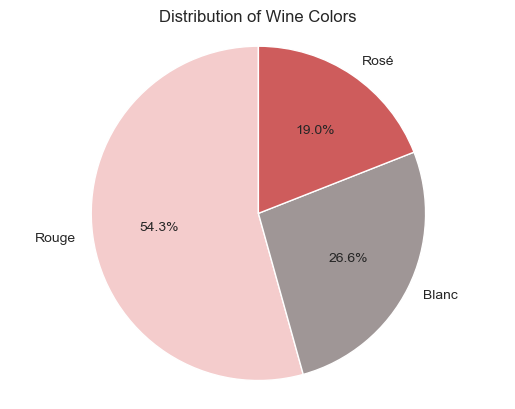

In [53]:
# Piechart avec matplot pour les vins
color_counts = df['couleur'].value_counts()


colors = ['#F4CCCC', '#9F9696', '#CE5C5C']


plt.pie(color_counts, labels=color_counts.index, colors=colors,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Wine Colors')
plt.show()


On peut observer une prépondérance des vins rouges sur cette marketPlace

Checkez la distribution des prix du vins

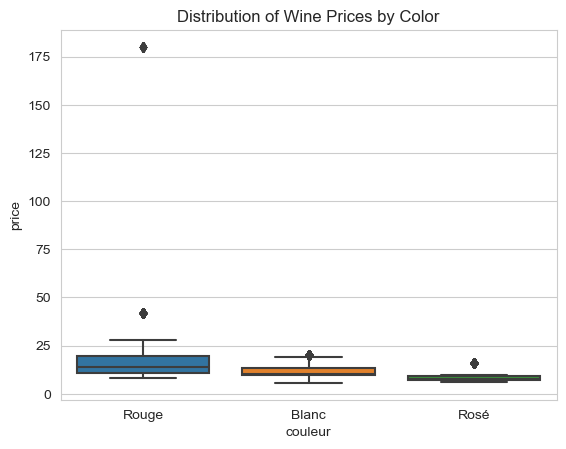

In [58]:


sns.set_style("whitegrid")
sns.boxplot(data=df, x='couleur', y='price')
plt.title('Distribution of Wine Prices by Color')
plt.show()


Post Observation , on se rend compte qu'il ya des outliers pour les vins . 
- celui du rouge est extrêment grand , et faussera sûrement sur la suite du traitement. ( on devra traiter les outliers ) 

Néanmoins, on observe: 
- Que le vin rouge coûte généralement plus chère que les autres vins ( peut être cela est dû a sa plus grande présence )
- Que les vins rosés sont mieux distribuer en terme de prix ( même tarif relatif)
- que le blanc cest trop bon 

Distribution d' alcool

<AxesSubplot:xlabel='degre_alcool', ylabel='Count'>

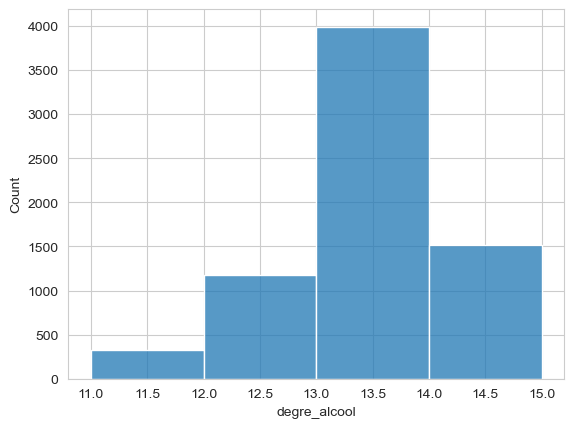

In [61]:

sns.histplot(data=df, x='degre_alcool', bins=4)

Relation  entre le degrée d'alcool  et le prix du vin

<AxesSubplot:xlabel='degre_alcool', ylabel='price'>

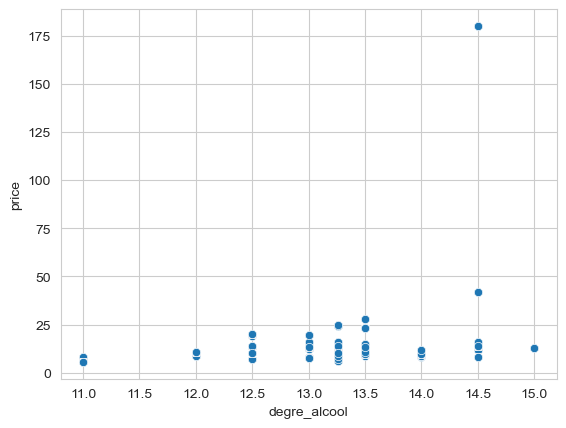

In [62]:


sns.scatterplot(data=df, x='degre_alcool', y='price')

Verification de la correlation entre les valeurs via heatmap

<AxesSubplot:>

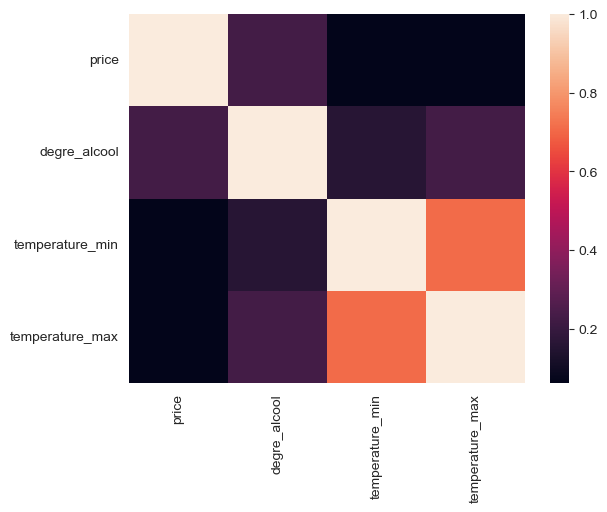

In [69]:

sns.heatmap(data=df[['price', 'degre_alcool', 'temperature_min', 'temperature_max']].corr())

on observe la correlation légère entre les différentes est plutôt faible entre chaque feature

Observation des prix au fil du temps 

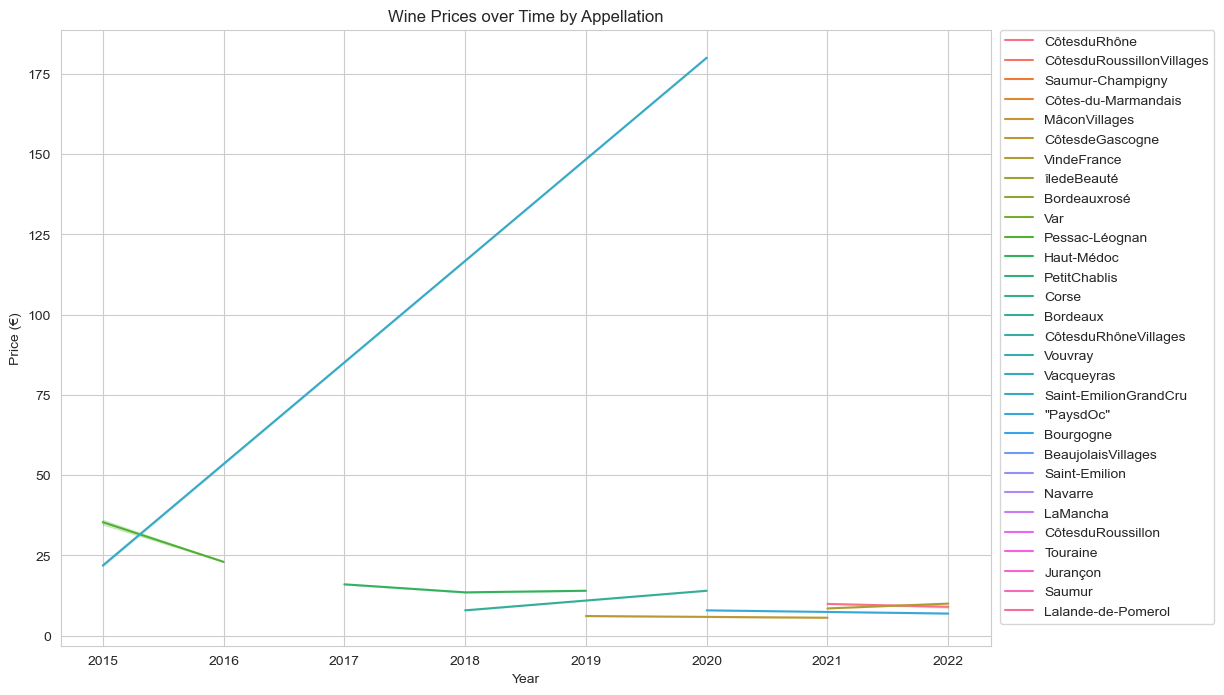

In [68]:

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.lineplot(data=df, x='millesime', y='price', hue='appellation')
ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.title('Wine Prices over Time by Appellation')
plt.xlabel('Year')
plt.ylabel('Price (€)')
plt.show()

Observation  : le prix du bougogne a explosé au fil des années 

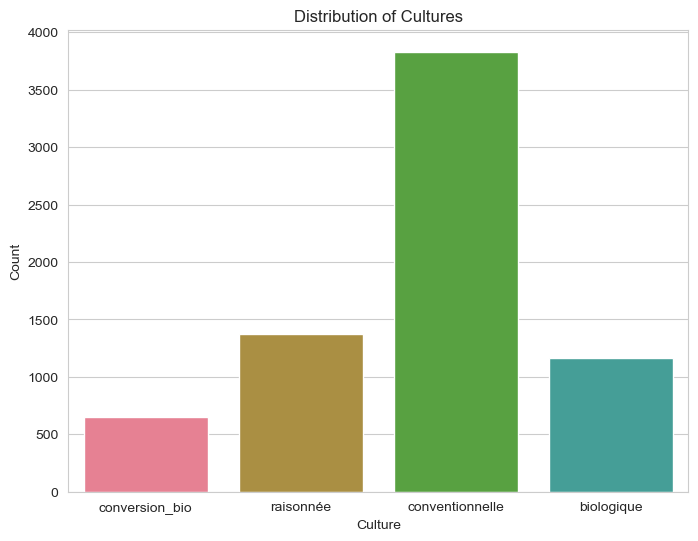

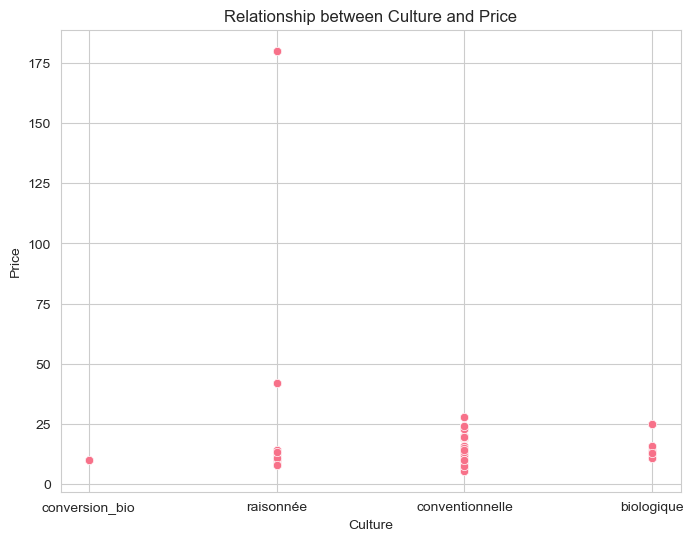

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Distribution of cultures
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='culture')
plt.title('Distribution of Cultures')
plt.xlabel('Culture')
plt.ylabel('Count')
plt.show()

# Scatter plot of culture vs price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='culture', y='price')
plt.title('Relationship between Culture and Price')
plt.xlabel('Culture')
plt.ylabel('Price')
plt.show()





Rapport Prix et Cepages

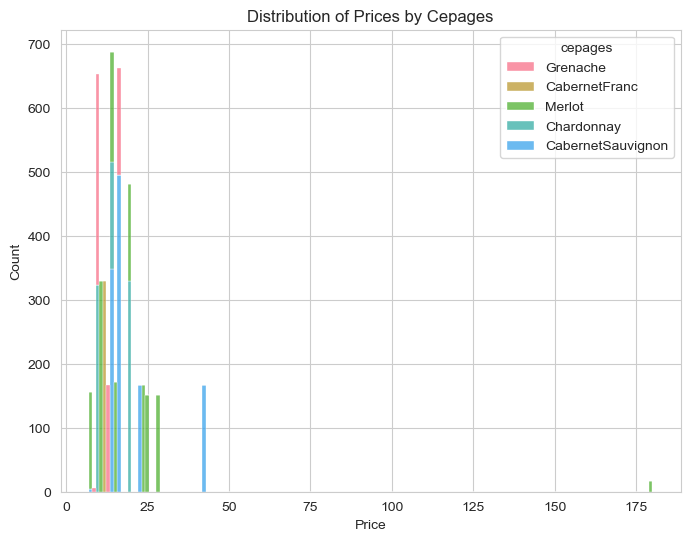

In [76]:
top_cepages = df['cepages'].value_counts().index[:5]
plt.figure(figsize=(8, 6))
sns.histplot(data=df[df['cepages'].isin(top_cepages)], x='price', hue='cepages', multiple='stack')
plt.title('Distribution of Prices by Cepages')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

- Préponderance des cabernets sauvignon . 
- Les merlot ont une distribution de prix equilibrés
- les grenaches sont les vins les moins chers , mais bien présent dans le top 5 des vins 

Rapport Prix Appellation

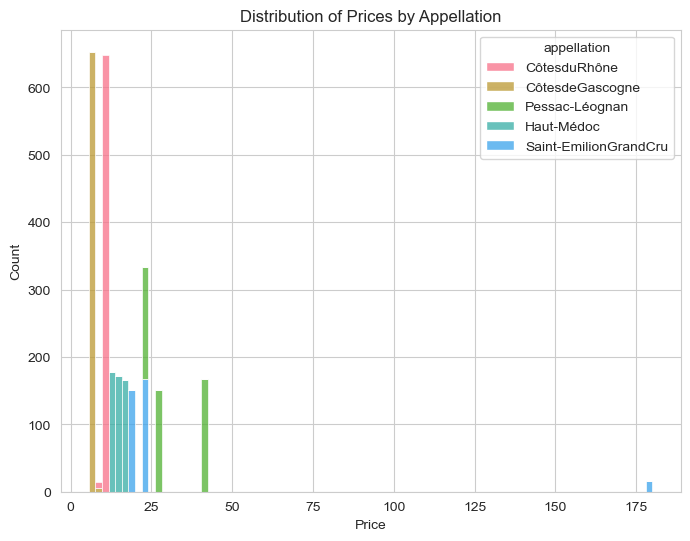

In [77]:
top_appellations = df['appellation'].value_counts().index[:5]
plt.figure(figsize=(8, 6))
sns.histplot(data=df[df['appellation'].isin(top_appellations)], x='price', hue='appellation', multiple='stack')
plt.title('Distribution of Prices by Appellation')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

on observe l'appelation : 
- Cote de Gascogne est peux rentable ( plus faible prix )
- Pessac-Léognang est  plus coûteuse  en prix 
- le Haut de Medoc sequilvre dans la fourchette basse
- Le sait Emilion est dan sla moyenne
- Cote du Rhone est exprimé unique dans la fourchette basse et n'est pas distribué 

## Export to CSV to make the streamlit app

In [80]:

df.to_csv('wine.csv', index=False)

Avec tout ces plots , on a une meilleure idée de ce quon va déployer par la suite 